<h1>Use Random Forest to predict the max temperature for tomorrow using one year of past weather data</h1>

## Importing libraries

In [1]:
# Import all packages needed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from evaluation_scores import get_regression_metrics, plot_true_pred, plot_residual

## Importing the dataset

In [2]:
# Import data here
dataset = pd.read_csv('temps.csv')

In [3]:
# Display some samples
dataset.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [4]:
# Quick info about the dataset 
dataset.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [5]:
dataset.dtypes

year                int64
month               int64
day                 int64
week               object
temp_2              int64
temp_1              int64
average           float64
actual              int64
forecast_noaa       int64
forecast_acc        int64
forecast_under      int64
friend              int64
dtype: object

**There are 9 columns in the data** :

> year: 2016 for all data points

> month: number for month of the year

> day: number for day of the year

> week: day of the week as a character string

> temp_2: max temperature 2 days prior

> temp_1: max temperature 1 day prior

> average: historical average max temperature

> actual: max temperature measurement

> friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

## Data Exploration

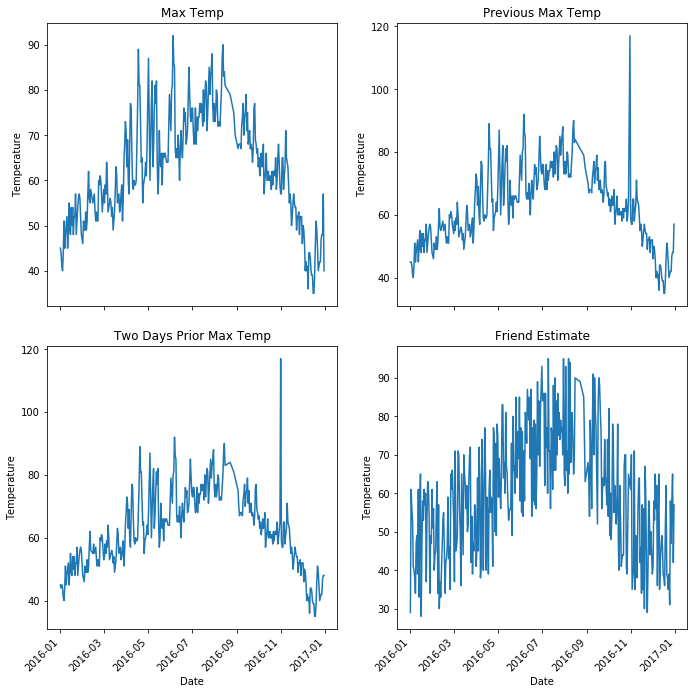

In [6]:
# Get years, months, and days
years = dataset['year']
months = dataset['month']
days = dataset['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, dataset['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, dataset['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, dataset['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, dataset['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

<p> Comment about the data exploration<p>

## Prepare the data

In [7]:
# One-hot encode categorical features
dataset = pd.get_dummies(dataset)
dataset.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [8]:
print('Shape of features after one-hot encoding:', dataset.shape)

Shape of features after one-hot encoding: (348, 18)


In [9]:
features_list = dataset.columns.difference(['actual']).tolist()
X = dataset[features_list].values
y = dataset['actual'].values

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(['X_train Shape:', X_train.shape], ['y_train Shape:', y_train.shape])
print(['X_test Shape:', X_test.shape], ['y_test Shape:', y_test.shape])

['X_train Shape:', (261, 17)] ['y_train Shape:', (261,)]
['X_test Shape:', (87, 17)] ['y_test Shape:', (87,)]


## Model the data

In [11]:
# Build model(s) here
model = RandomForestRegressor(n_estimators= 1000,
                              criterion='mse',
                              max_depth=None,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              max_features='auto',
                              bootstrap=True,
                              n_jobs=-1,
                              verbose=1,
                              random_state=42)
# Train the model on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [12]:
# Prediction on test data
y_test_pred = model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [13]:
# Evaluate model
get_regression_metrics(y_test, y_test_pred)

,Value
MAE,3.872540
RMSE,5.110953
min_error,0.056000
max_error,18.119000
R^2,0.812166
25% error,1.325000
50% error,2.963000
95% error,9.419000
MNE,-2.748750
MPE,4.828957


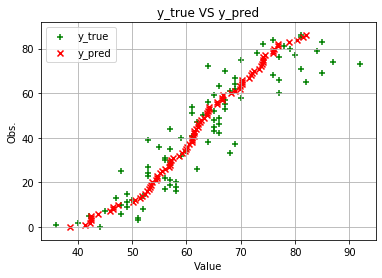

In [14]:
plot_true_pred(pd.Series(y_test), pd.Series(y_test_pred))

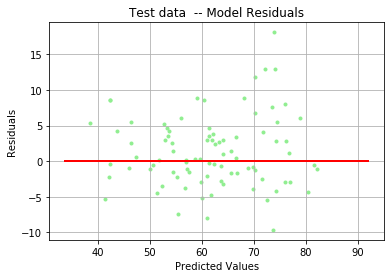

In [15]:
plot_residual(y_test, y_test_pred)

In [23]:
importances = list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print('Feature importances : \n')
[print('{:15}  : {}'.format(*pair)) for pair in feature_importances];

Feature importances : 

temp_1           : 0.66
average          : 0.15
forecast_noaa    : 0.05
forecast_acc     : 0.03
day              : 0.02
forecast_under   : 0.02
friend           : 0.02
temp_2           : 0.02
month            : 0.01
week_Fri         : 0.0
week_Mon         : 0.0
week_Sat         : 0.0
week_Sun         : 0.0
week_Thurs       : 0.0
week_Tues        : 0.0
week_Wed         : 0.0
year             : 0.0


## Fine-tune the models

In [16]:
# Tune model(s) here

## Present the solution

In [17]:
# Present model(s)'s perfomances to clients